
## Do Teams that make it to championship have teams that are more likely to get drafted? 

We will be exploring this question by loooking at the relationship the Talent Score, the ELO, and the percent that were drafted. 

In [60]:
# Uncomment to get the correct versions
# from IPython.display import clear_output
# !pip install -r requirements.txt
# clear_output() 


In [61]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.ticker as mticker
import warnings 


In [62]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


In [63]:
df_draft = pd.read_csv('../data/draft.csv')
df_draft = df_draft.rename(columns={'College/Univ': 'team'})
columns = ['Player', 'team', 'draft_year']
df_draft = df_draft[columns] 
print(df_draft.head().to_markdown())

|    | Player        | team             |   draft_year |
|---:|:--------------|:-----------------|-------------:|
|  0 | Eric Fisher   | Central Michigan |         2013 |
|  1 | Luke Joeckel  | Texas A&M        |         2013 |
|  2 | Dion Jordan   | Oregon           |         2013 |
|  3 | Lane Johnson  | Oklahoma         |         2013 |
|  4 | Ezekiel Ansah | BYU              |         2013 |


In [64]:
df_roster = pd.read_csv('../data/roster.csv',low_memory=False)

# Combine first and last name in draft data to get player from roster
df_roster['Player'] = df_roster['first_name'] + ' '+ df_roster['last_name']
columns = ['Player', 'team', 'year']
df_roster = df_roster[columns]
print(df_roster.head().to_markdown())


|    | Player           | team             |   year |
|---:|:-----------------|:-----------------|-------:|
|  0 | Justin Johnson   | Fresno State     |   2015 |
|  1 | Jamaal Jackson   | Delaware State   |   2015 |
|  2 | Johnny Jackson   | Arizona          |   2015 |
|  3 | Jason Johnson    | Western Kentucky |   2015 |
|  4 | Nicholas Peoples | Grambling        |   2015 |


In [65]:
merged_df = pd.merge(left = df_roster , right = df_draft, how = 'left', left_on = ['team', 'Player'], right_on= ['team', 'Player'])
merged_df = merged_df.drop_duplicates()
merged_df['draft_flag'] = merged_df['draft_year'].notnull().astype(int)

print(merged_df.head().to_markdown() )

|    | Player           | team             |   year |   draft_year |   draft_flag |
|---:|:-----------------|:-----------------|-------:|-------------:|-------------:|
|  0 | Justin Johnson   | Fresno State     |   2015 |          nan |            0 |
|  1 | Jamaal Jackson   | Delaware State   |   2015 |          nan |            0 |
|  2 | Johnny Jackson   | Arizona          |   2015 |          nan |            0 |
|  3 | Jason Johnson    | Western Kentucky |   2015 |          nan |            0 |
|  4 | Nicholas Peoples | Grambling        |   2015 |          nan |            0 |


### Data Manipulation

In [66]:
# Add in the teams data
df = pd.read_csv('../data/games_manipulated.csv', low_memory=False)
df_team_talent = pd.read_csv('../data/team_talent.csv',low_memory=False)
# print(df.columns) 
power_5_conf = ['Pac-12', 'Big 12', 'ACC', 'SEC', 'Big Ten']

df = df[df['game_that_season'] == 12][['season','main_team', 'team_conference', 'team_postgame_elo']] # unique name 
df = df[df['team_conference'].isin(power_5_conf)]

schools_filtered = df['main_team'].unique() # schools that are in the power 5 conf 
df = df[df['season'] != 2020] # outliar
df = df.rename(columns={'main_team': 'school', 'season': 'year'})

print(df.head().to_markdown(), '\n')
print(df_team_talent.head().to_markdown() )
df_teams_data_combined = pd.merge(df, df_team_talent,  how = 'inner', left_on=['school', 'year'], right_on=['school', 'year'])
print(df_teams_data_combined.head().to_markdown())

|     |   year | school         | team_conference   |   team_postgame_elo |
|----:|-------:|:---------------|:------------------|--------------------:|
|  56 |   2023 | UCF            | Big 12            |                1658 |
| 120 |   2015 | South Carolina | SEC               |                1579 |
| 135 |   2017 | South Carolina | SEC               |                1572 |
| 142 |   2018 | South Carolina | SEC               |                1641 |
| 149 |   2019 | South Carolina | SEC               |                1497 | 

|    |   year | school        |   talent |
|---:|-------:|:--------------|---------:|
|  0 |   2015 | Alabama       |   981.9  |
|  1 |   2015 | USC           |   926.71 |
|  2 |   2015 | Ohio State    |   907.32 |
|  3 |   2015 | Florida State |   889.92 |
|  4 |   2015 | LSU           |   889.37 |
|    |   year | school         | team_conference   |   team_postgame_elo |   talent |
|---:|-------:|:---------------|:------------------|--------------------:|-----

In [67]:
# merged_df.head() 
combine_draft_team = pd.merge(merged_df, df_teams_data_combined, how='left',  left_on=['team', 'year'], right_on=['school', 'year'])
combine_draft_team = combine_draft_team[combine_draft_team['team'].isin(schools_filtered)]
combine_draft_team.head() 

,Player,team,year,draft_year,draft_flag,school,team_conference,team_postgame_elo,talent
2,Johnny Jackson,Arizona,2015,NaN,0,Arizona,Pac-12,1495.0,606.92
7,Josh Moore,Missouri,2015,NaN,0,Missouri,SEC,1557.0,642.93
8,Brian Smith,Minnesota,2015,NaN,0,Minnesota,Big Ten,1582.0,516.10
12,Brett Johnson,California,2015,NaN,0,California,Pac-12,1567.0,626.00
13,Kyle Williams,Arizona State,2015,NaN,0,Arizona State,Pac-12,1666.0,680.87


In [68]:
df = pd.read_csv('../data/games_manipulated.csv', low_memory=False)

print(df.head().to_markdown(), '\n')

# Get the Championship flag 
substr_1 = 'NATIONAL CHAMPIONSHIP'
substr_2 = 'National Championship'

df = df[df['notes'].notna()]
a = df[df['notes'].str.contains(substr_1)]
b = df[df['notes'].str.contains(substr_2)]

championship_games = pd.concat([a, b])
championship_games['championship_appearance'] = 1
championship_games = championship_games.sort_values(by = 'season', ascending = True)[['main_team', 'season', 'win_flag', 'championship_appearance']]

championship_games= championship_games.rename(columns={'main_team': 'school', 'season': 'year'})
print(championship_games.to_markdown())

# Check that there are two teams perseason that went to the championship 
# championship_games.groupby('season')['championship_appearance'].count()

|    |   Unnamed: 0 |   index |        id |   season |   week | season_type   | start_date               |   start_time_tbd | completed   | neutral_site   | conference_game   |   attendance |   venue_id | venue                         |   excitement_index |   highlights |   notes | main_team   |   home_game_flag |   team_id |   opposing_team_id | team_conference   | opposing_conference   |   points_for |   points_against |   point_differential | team_line_scores   | opposing_line_scores   |   team_pregame_elo |   team_postgame_elo |   opponent_pregame_elo |   opponent_postgame_elo |   win_flag |   game_that_season |
|---:|-------------:|--------:|----------:|---------:|-------:|:--------------|:-------------------------|-----------------:|:------------|:---------------|:------------------|-------------:|-----------:|:------------------------------|-------------------:|-------------:|--------:|:------------|-----------------:|----------:|-------------------:|:------------------|:-------

In [69]:
# Add championship 
combine_draft_team = pd.merge(combine_draft_team, championship_games, how='left',  left_on=['school', 'year'], right_on=['school', 'year'])
combine_draft_team['championship_appearance'].fillna(0, inplace=True)
combine_draft_team.head()

,Player,team,year,draft_year,draft_flag,school,team_conference,team_postgame_elo,talent,win_flag,championship_appearance
0,Johnny Jackson,Arizona,2015,NaN,0,Arizona,Pac-12,1495.0,606.92,NaN,0.0
1,Josh Moore,Missouri,2015,NaN,0,Missouri,SEC,1557.0,642.93,NaN,0.0
2,Brian Smith,Minnesota,2015,NaN,0,Minnesota,Big Ten,1582.0,516.10,NaN,0.0
3,Brett Johnson,California,2015,NaN,0,California,Pac-12,1567.0,626.00,NaN,0.0
4,Kyle Williams,Arizona State,2015,NaN,0,Arizona State,Pac-12,1666.0,680.87,NaN,0.0


In [70]:
grouped_data = combine_draft_team.groupby(['team', 'year', 'talent', 'team_postgame_elo', 'championship_appearance']).agg({'draft_flag': ['count', 'sum']})
grouped_data['draft_percentage'] = (grouped_data['draft_flag']['sum'] / grouped_data['draft_flag']['count']) * 100
grouped_data.columns = grouped_data.columns.droplevel(0)
grouped_data.columns = ['count_draft_flag', 'sum_draft_flag', 'draft_percentage']
grouped_data.reset_index(inplace=True) 
print(grouped_data.head().to_markdown())

|    | team    |   year |   talent |   team_postgame_elo |   championship_appearance |   count_draft_flag |   sum_draft_flag |   draft_percentage |
|---:|:--------|-------:|---------:|--------------------:|--------------------------:|-------------------:|-----------------:|-------------------:|
|  0 | Alabama |   2015 |   981.9  |                2097 |                         1 |                 71 |               28 |            39.4366 |
|  1 | Alabama |   2016 |   982.66 |                2278 |                         1 |                 88 |               32 |            36.3636 |
|  2 | Alabama |   2017 |   997.57 |                2206 |                         1 |                 92 |               35 |            38.0435 |
|  3 | Alabama |   2018 |   978.54 |                2336 |                         1 |                 98 |               30 |            30.6122 |
|  4 | Alabama |   2019 |   984.96 |                2160 |                         0 |                126 |     

### Analyse Data

In [71]:
grouped_data = grouped_data.rename(columns={'championship_appearance': 'Appear in Championships', 'draft_percentage': 'Percentage of Team Drafted'})
grouped_data.head() 

,team,year,talent,team_postgame_elo,Appear in Championships,count_draft_flag,sum_draft_flag,Percentage of Team Drafted
0,Alabama,2015,981.90,2097.0,1.0,71,28,39.436620
1,Alabama,2016,982.66,2278.0,1.0,88,32,36.363636
2,Alabama,2017,997.57,2206.0,1.0,92,35,38.043478
3,Alabama,2018,978.54,2336.0,1.0,98,30,30.612245
4,Alabama,2019,984.96,2160.0,0.0,126,29,23.015873


In [72]:
grouped_data['Appear in Championships Flag'] = np.where(grouped_data['Appear in Championships'] == 0.0, 'No', 'Yes')

In [73]:
grouped_data.head() 

,team,year,talent,team_postgame_elo,Appear in Championships,count_draft_flag,sum_draft_flag,Percentage of Team Drafted,Appear in Championships Flag
0,Alabama,2015,981.90,2097.0,1.0,71,28,39.436620,Yes
1,Alabama,2016,982.66,2278.0,1.0,88,32,36.363636,Yes
2,Alabama,2017,997.57,2206.0,1.0,92,35,38.043478,Yes
3,Alabama,2018,978.54,2336.0,1.0,98,30,30.612245,Yes
4,Alabama,2019,984.96,2160.0,0.0,126,29,23.015873,No


###  Figure 2: Sample DataFrame


In [74]:
correlation_matrix = grouped_data[['talent', 'team_postgame_elo', 'Percentage of Team Drafted']].corr()
final_df = pd.DataFrame(correlation_matrix['Percentage of Team Drafted']).drop('Percentage of Team Drafted',axis=0  )
print(final_df.to_markdown())


|                   |   Percentage of Team Drafted |
|:------------------|-----------------------------:|
| talent            |                     0.342718 |
| team_postgame_elo |                     0.386975 |


In [75]:
michigan_2023 = grouped_data[(grouped_data['team'] == 'Michigan') & (grouped_data['year'] == 2023)][['team','year','team_postgame_elo', 'talent']]
michigan_2023

,team,year,team_postgame_elo,talent
215,Michigan,2023,2165.0,850.43


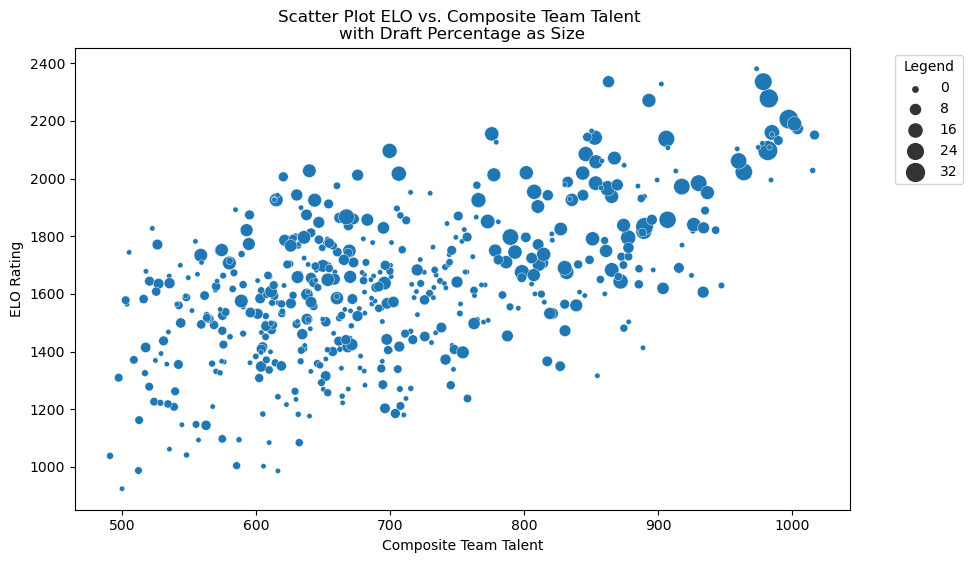

In [76]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

sns.scatterplot(data=grouped_data, x='talent', y='team_postgame_elo', size='Percentage of Team Drafted', sizes=(15, 200))

plt.title('Scatter Plot ELO vs. Composite Team Talent \nwith Draft Percentage as Size')
plt.xlabel('Composite Team Talent')
plt.ylabel('ELO Rating')

# Move the legend outside of the chart
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


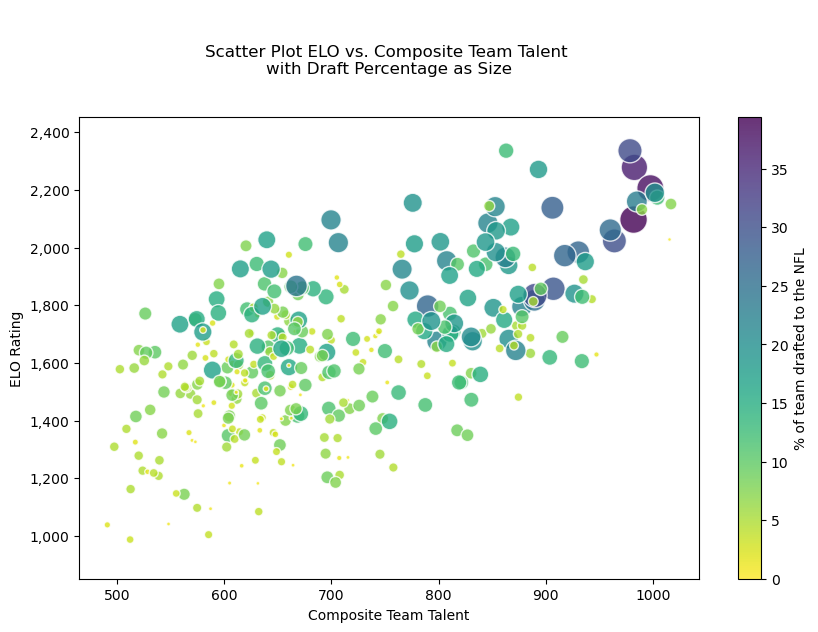

In [77]:

plt.figure(figsize=(10, 6))  # Set the size of the figure

cmap = plt.cm.viridis  # You can choose any colormap here
reversed_cmap = cmap.reversed()  # Reversed colormap


print(formatter)
plt.scatter(grouped_data['talent'], grouped_data['team_postgame_elo'],s=grouped_data['Percentage of Team Drafted']*10, c=grouped_data['Percentage of Team Drafted'], cmap=reversed_cmap, alpha=0.8, edgecolors='w', linewidth=1)
plt.colorbar(label='% of team drafted to the NFL')

formatter = mticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('\n\nScatter Plot ELO vs. Composite Team Talent \nwith Draft Percentage as Size\n\n')
plt.xlabel('Composite Team Talent')
plt.ylabel('ELO Rating')

plt.show() 



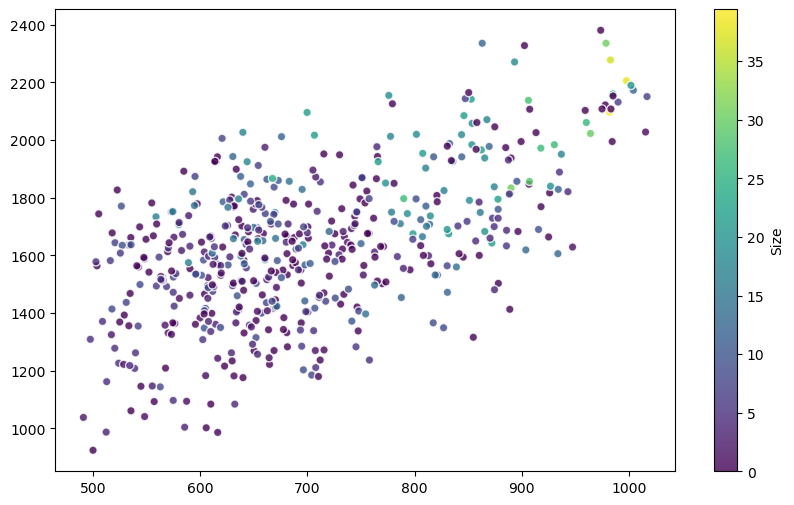

In [78]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

norm = plt.Normalize(grouped_data['Percentage of Team Drafted'].min(), grouped_data['Percentage of Team Drafted'].max())
cmap = plt.cm.viridis  # You can choose any colormap here


plt.scatter(grouped_data['talent'], grouped_data['team_postgame_elo'], c=grouped_data['Percentage of Team Drafted'], cmap=cmap, alpha=0.8, edgecolors='w', linewidth=1)
plt.colorbar(label='Size')

plt.show() 

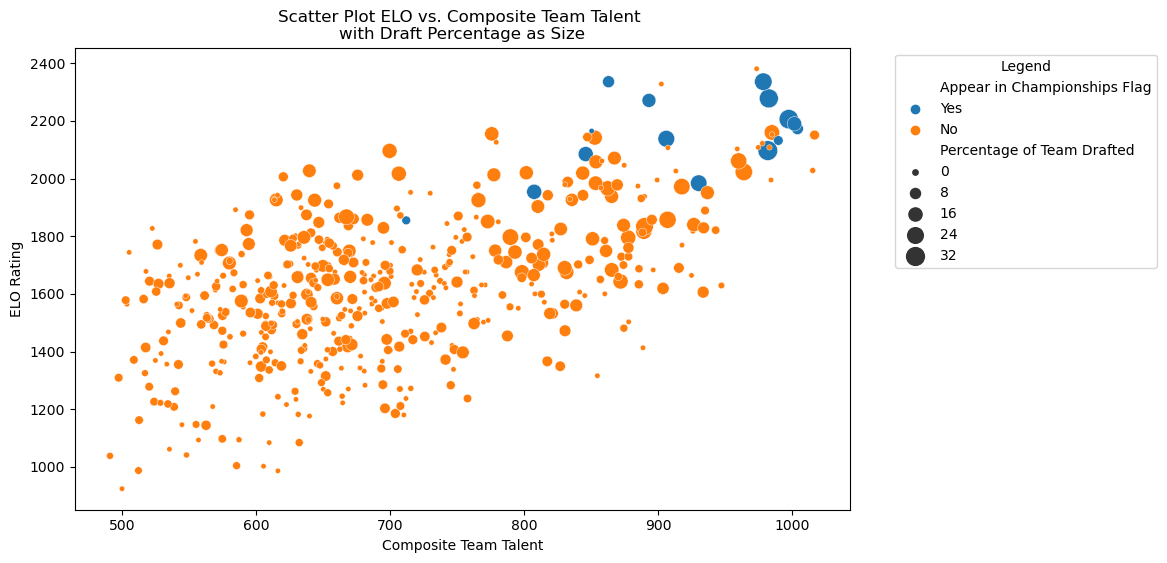

In [79]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

sns.scatterplot(data=grouped_data, x='talent', y='team_postgame_elo', hue='Appear in Championships Flag', size='Percentage of Team Drafted', sizes=(15, 200))

plt.title('Scatter Plot ELO vs. Composite Team Talent \nwith Draft Percentage as Size')
plt.xlabel('Composite Team Talent')
plt.ylabel('ELO Rating')

# Move the legend outside of the chart
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


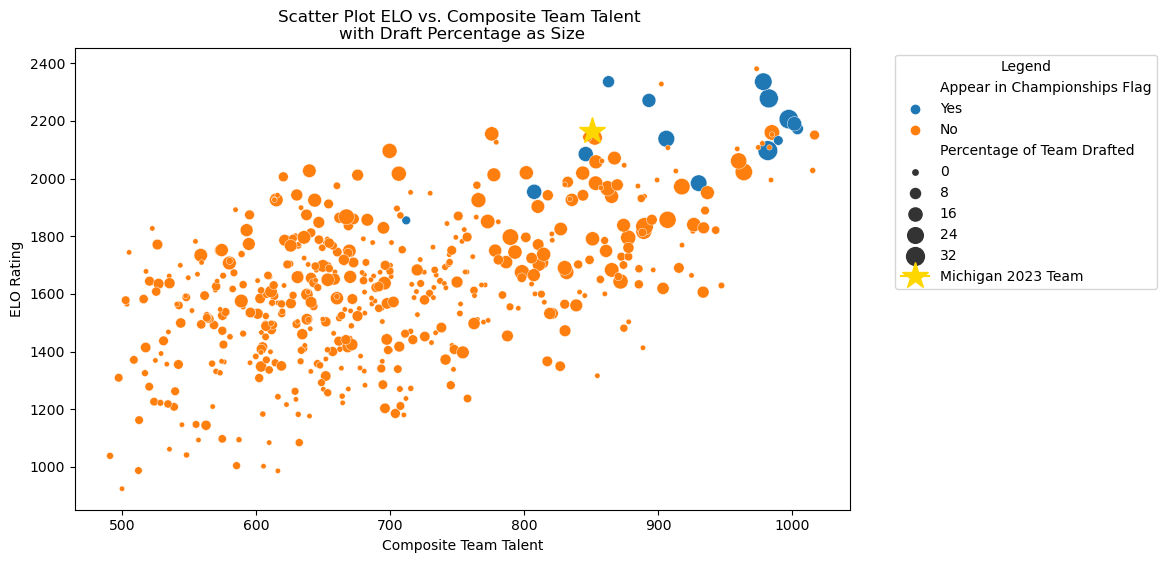

In [80]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

sns.scatterplot(data=grouped_data, x='talent', y='team_postgame_elo', hue='Appear in Championships Flag', size='Percentage of Team Drafted', sizes=(15, 200))
plt.plot(michigan_2023['talent'], michigan_2023['team_postgame_elo'], marker='*', markersize=20, color='gold', label='Michigan 2023 Team')

plt.title('Scatter Plot ELO vs. Composite Team Talent \nwith Draft Percentage as Size')
plt.xlabel('Composite Team Talent')
plt.ylabel('ELO Rating')

# Move the legend outside of the chart
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


As you can see the higher the ELO rating of the team and the higher th composite team talent, the more likely players will be drafted into the next year. 